<font size=5  color=#003366> **[LELEC2900] - Signal Processing <br><br> 
Python Evaluation - Part II** </font> <br><br><br>

<font size=5  color=#003366>
Prof. L. Vandendorpe<br>
Prof. L. Jacques
<br><br>
Anne-Sophie Collin (anne-sophie.collin@uclouvain.be)<br> 
Florian Quatresooz (florian.quatresooz@uclouvain.be) <br>
<br><br>
</font>

<font size=6 color=#009999> Overall instructions </font> <br>
- You have two hours to fill in this notebook.
- For each code cell, we specify if you must simply run it (`TO RUN`) or complete some code (`TO COMPLETE`). 
- Once you are done or the deadline (6.15pm) is approaching, save the notebook as `Evaluation2-Lastname-Firstname.ipynb` <b>with your outputs</b> and upload it on the moodle main page (there is a submission module on its main page).

<br>
Remarks:
- The final result is not the only thing that matters. The code clarity (which may imply comments) and answers to questions matter as well.
- If you are stuck, please add comments in code cells explaining why you feel you are stuck, what is your understanding of the situation.

<br>
<font size=6 color=#009999> PART I: KALMAN PREDICTOR AGAINST WRONG OBSERVATION
    </font> <br>
<br>

In this exercise, you will enrich your original Kalman predictor by making it robust against a wrong measurement. First, you will try to detect a wrong measurement based on the covariance estimate. Then, you will design a method that allows your predictor to ignore one wrong observation. 

Note that we are working in the exact same context as in the Python05 session, i.e. track the trajectory of a ballistic missile with the same problem modelisation. All the necessary constants and matrices are written in the following cell.

In [1]:
##########################################################################
# TO RUN
##########################################################################
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Define all the parameters 

# Matrices A,Bu, G and C 
dt = 0.4 # seconds
A  = np.array([[1., dt, 0., 0.],   
              [0., 1., 0., 0.], 
              [0., 0., 1., dt], 
              [0., 0., 0., 1.]])  
g  = 9.81 #meter per second^2
Bu = np.array([[0., 0., 0., -g*dt]]).T
C  = np.array([[1., 0., 0., 0.],
              [0., 0., 1., 0.]])
G  = np.array([[1., 0., 0., 0.],   
              [0., 1., 0., 0.], 
              [0., 0., 1., 0.], 
              [0., 0., 0., 1.]])  

# Matrices Q, R and P_0
sigma_1 = 0.5
sigma_2 = 0.5
sigma_3 = 1.5
sigma_4 = 0.5
Q   = np.array([[sigma_1**2, 0, 0., 0.],   
              [0., sigma_2**2, 0., 0.], 
              [0., 0., sigma_1**2, 0], 
              [0., 0., 0., sigma_2**2]]) 
R   = np.array([[sigma_3**2, 0],   
              [0., sigma_3**2]]) 
P_0 = np.array([[sigma_4**2, 0, 0., 0.],   
              [0., 0, 0., 0.], 
              [0., 0., sigma_4**2, 0], 
              [0., 0., 0., 0]]) 

# Initial states
x0bar    = 15   # meter
y0bar    = 15   # meter
vx0bar   = 70   # meter per second
vy0bar   = 70   # meter per second
x0barvec = np.array([[x0bar, vx0bar, y0bar, vy0bar]]).T

# Number of time steps
Nsteps = 35


<br>
<font size=6 color=#009999> 1. Observe the recorded trajectory </font> <br>
<br>

We stored the observations in the `observations.npy` file available on Moodle. Run the following cell to obtain a plot of the observations with a wrong measurement. 

Text(0, 0.5, 'Vertical position')

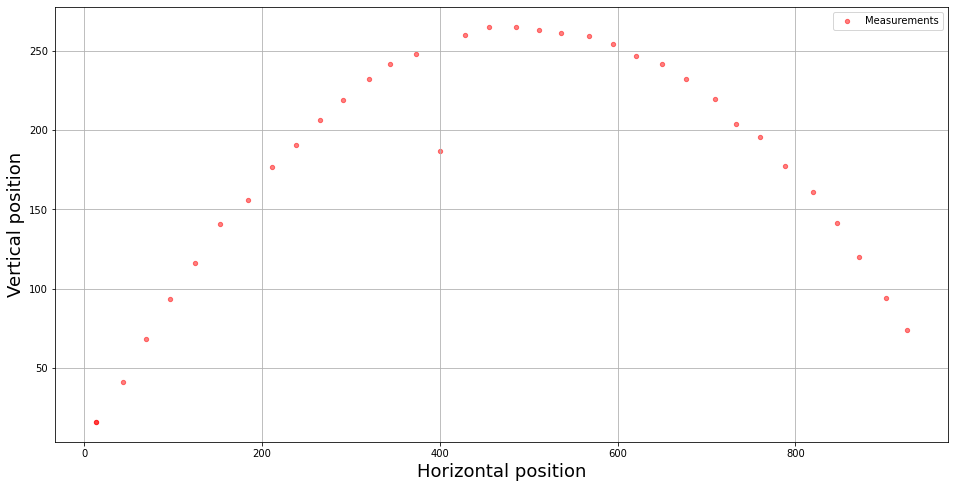

In [2]:
##########################################################################
# TO RUN
##########################################################################
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Read the measurements made over our ballistic trajectory
obs = np.load("Data/observations.npy")

plt.figure(figsize=(16, 8))
plt.grid()
plt.scatter(obs[:,0], obs[:,1], color='r', marker='.', s=75, alpha=0.5, label='Measurements')
plt.legend()
plt.xlabel('Horizontal position', fontsize=18)
plt.ylabel('Vertical position', fontsize=18) 

Based on such a plot, it is easy to identify the measurement which deviates from the global trajectory. However, in a real-time scenario, you do not have access to the entire observation vector but only to the current and previous measurements. Hence, the detection of wrong observation can not take future observations into account. 

<br>
<font size=6 color=#009999> 2. Detect wrong observations </font> <br>
<br>

Our detection method will be as follow: At each iteration of the `Kalman_predictor` loop, you only have access to an evaluation of the state vector $\hat{\textbf{x}}_{k+1|k}$ and the posteriori accuracy ($P_{k+1|k}$), the future trajectory and observations are still unknown. For the shake of simplicity, we will get rid of the temporal indices in the notation : $\hat{\textbf{x}}_{k+1|k} \rightarrow \hat{\textbf{x}}$ and $P_{k+1|k} \rightarrow P$. The objective is to detect an observation which lies outside the distribution parametrized by a mean $\textbf{x}$ and a covariance matrix $P$. Note that velocity estimation will be ignored since we observe only the object horizontal/vertical position. 

An observation $\textbf{y}$ will be detected as abnormal if: 

$$ | \textbf{y}_{\text{hor.}} - \hat{\textbf{x}}_{\text{hor.}} | > 6~ \sigma^2_{\text{hor.}} ~~~\text{or} ~~~ | \textbf{y}_{\text{vert.}} - \hat{\textbf{x}}_{\text{vert.}} | > 6~ \sigma^2_{\text{vert.}} $$
where $\textbf{y}_{\text{hor.}}$ denotes the observed position along the horizontal axis (resp. $\textbf{y}_{\text{vert.}}$ along the vertical axis) and $\hat{\textbf{x}}_{\text{hor.}}$ denotes the estimated position along the horizontal axis (resp. $\hat{\textbf{x}}_{\text{vert.}}$ along the vertical axis). $\sigma^2_{\text{hor.}}$ is the estimated variance about the position in the horizontal direction (resp. $\sigma^2_{\text{vert.}}$ is the variance in the vertical direction) as encoded in the matrix $P$. 


<div class="alert alert-block alert-info">
<font color=#0053B6>
<b> Question 1 </b><br> 
Complete the following cell with your own `Kalman_predictor_with_detection` function. The core of this function is identical as the `Kalman_predictor` function from the practical session. You should only add the detection of abnormal observation as described above. If one measure lies outise the normal range, print the following message: <br> 
<samp>print(f'unlikely observation at time step ', str(k))</samp>
with k beeing the observation's index.
<br>
</font>

In [66]:
##########################################################################
# TO COMPLETE
##########################################################################

def Kalman_predictor_with_detection(A,Bu,C,G,Q,R,P_0,x0barvec,Measurements,Nsteps):
    Predicted_states =x0barvec.T     
    Measurements = Measurements[1:]
    P = P_0
    P_list = [P_0]
    for k in range(Nsteps):
        # Retreave the last predicted and observed
        x_k_k1 = np.expand_dims(Predicted_states[-1],1)
        y_k = np.expand_dims(Measurements[k],1)
        
        
        
        K_k = A@P@C.T@np.linalg.inv(C@P@C.T+R)
        
    
        P = A@P@A.T+G@Q@G.T-K_k@C@P@A.T
        P_list.append(P)
        
        # Calculate the next prediction
        x_k1_k = (((A-K_k@C)@x_k_k1)+Bu+(K_k@y_k)).T
        
        # Calculate if the observation is unlikely
        if np.abs(y_k[0][0]-x_k_k1[0][0]) > 6*P[0][0] or np.abs(y_k[1][0]-x_k_k1[2][0]) > 6*P[2][2]:
            print(f'unlikely observation at time step ', str(k))
            #print(P)
            #print(y_k[0][0], x_k_k1[0][0],6*P[0][0])
            #print(y_k[1][0],x_k_k1[2][0],6*P[2][2])
            #print(x_k_k1)
            #print(y_k)
        
        Predicted_states = np.r_[Predicted_states,x_k1_k]
    
    
    return Predicted_states, P_list
    
    #insert your code here. 


<div class="alert alert-block alert-info">
<font color=#0053B6>
<b> Question 2 </b><br> 
Plot in the same graph:
<ol>
    <li> the observations;
    <li> the estimated trajectory obtained using the Kalman predictor;
    <li> for each prediction, a gaussian distribution of mean [$\hat{\textbf{x}}_x, \hat{\textbf{x}}_y$] and covariance matrix $\begin{bmatrix}
\sigma^2_x & 0 \\
0 & \sigma^2_y 
\end{bmatrix}$. You can use the function `plot_covariance_ellipse` to help you.
        
</ol>
</font>

unlikely observation at time step  14
unlikely observation at time step  15
unlikely observation at time step  16
unlikely observation at time step  17


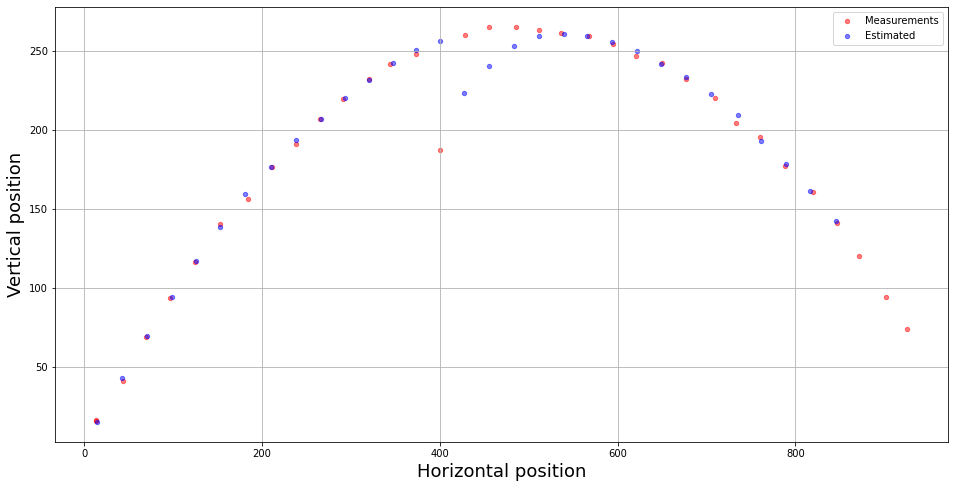

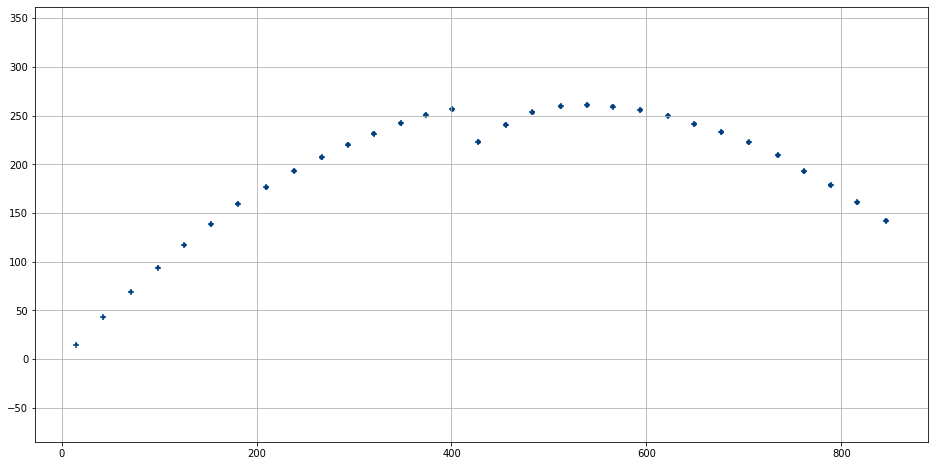

In [67]:
##########################################################################
# TO COMPLETE
##########################################################################

from make_graphs import plot_covariance_ellipse

#insert your code here. 
 
    
estimated,P_list = Kalman_predictor_with_detection(A,Bu,C,G,Q,R,P_0,x0barvec,obs,30)
    
    
    
plt.figure(figsize=(16, 8))
plt.grid()
plt.scatter(obs[:,0], obs[:,1], color='r', marker='.', s=75, alpha=0.5, label='Measurements')

plt.scatter(estimated[:,0], estimated[:,2], color='b', marker='.', s=75, alpha=0.5, label='Estimated')
plt.legend()
plt.xlabel('Horizontal position', fontsize=18)
plt.ylabel('Vertical position', fontsize=18) 

plt.figure(figsize=(16, 8))

for pos,P in zip(estimated,P_list):
    plot_covariance_ellipse([pos[0],pos[2]],[[P[0,0],0],[0,P[2,2]]])
    
plt.grid()


<br>
<font size=6 color=#009999> 3. Implement a robust predictor </font> <br>
<br>

<div class="alert alert-block alert-info">
<font color=#0053B6>
<b> Question 3 </b><br> 
Implement the `robust_Kalman_predictor` function, which is an extension of your `Kalman_predictor_with_detection` function. When an abnormal observation is detected (same procedure than before) replace the unlikely observation $\textbf{y}_{k}$ by $\hat{\textbf{x}}_{k|k-1}$. <br>
Then, provide the same plot than in Question 2 with this new prediction.
<br>
</font>

unlikely observation at time step  0
unlikely observation at time step  14


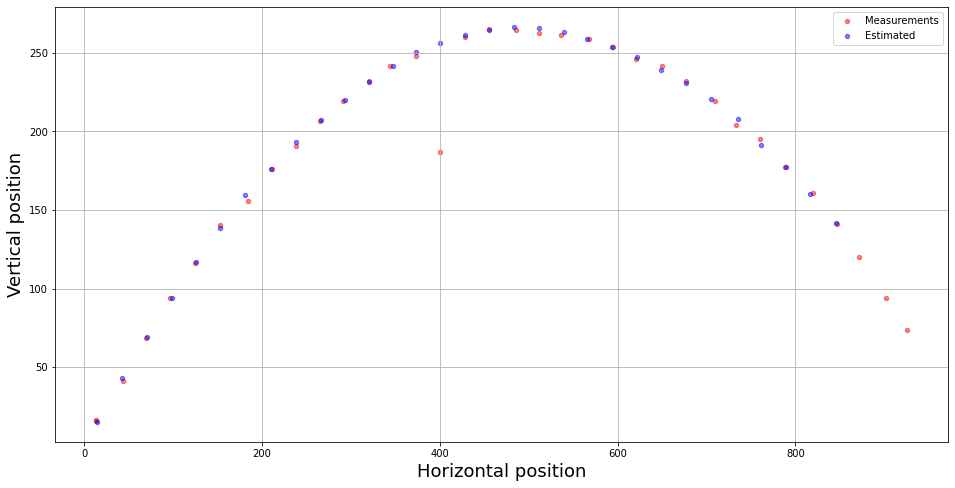

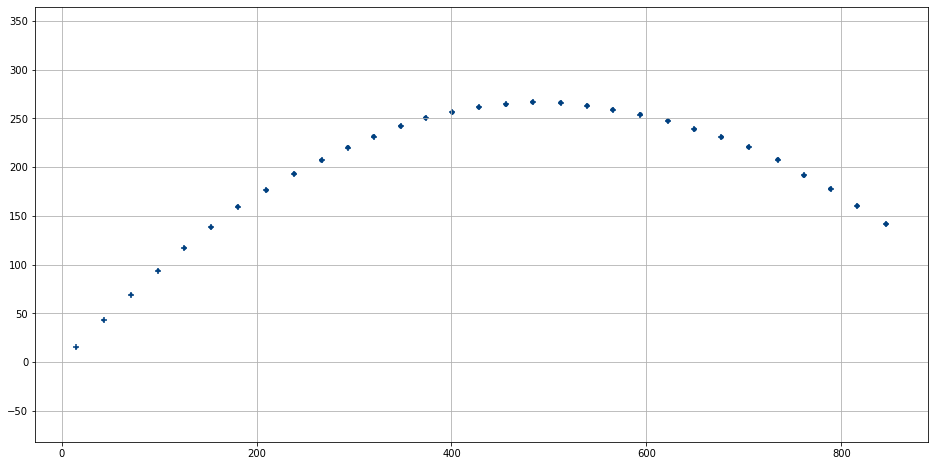

In [68]:
##########################################################################
# TO COMPLETE
##########################################################################

    
def robust_Kalman_predictor(A,Bu,C,G,Q,R,P_0,x0barvec,Measurements,Nsteps):
    Predicted_states =x0barvec.T     
    Measurements = Measurements[1:] # The two first measurement are very similar. I so choose to remove the first one as the result are more coherent
    P = P_0
    P_list = [P_0]
    for k in range(Nsteps):
        # Retreave the last predicted and observed
        x_k_k1 = np.expand_dims(Predicted_states[-1],1)
        y_k = np.expand_dims(Measurements[k],1)
        
        # Calculate if the observation is unlikely
        if np.abs(y_k[0][0]-x_k_k1[0][0]) > 6*P[0][0] or np.abs(y_k[1][0]-x_k_k1[2][0]) > 6*P[2][2]:
            print(f'unlikely observation at time step ', str(k))
            y_k = [x_k_k1[0],x_k_k1[2]]
            
             
        
        
        K_k = A@P@C.T@np.linalg.inv(C@P@C.T+R)
        
    
        P = A@P@A.T+G@Q@G.T-K_k@C@P@A.T
        P_list.append(P)
        
        # Calculate the next prediction
        x_k1_k = (((A-K_k@C)@x_k_k1)+Bu+(K_k@y_k)).T


        
        Predicted_states = np.r_[Predicted_states,x_k1_k]
    
    
    return Predicted_states, P_list
    #insert your code here.
    
    
    
    
    
    
    
estimated,P_list = robust_Kalman_predictor(A,Bu,C,G,Q,R,P_0,x0barvec,obs,30)
    
    
    
plt.figure(figsize=(16, 8))
plt.grid()
plt.scatter(obs[:,0], obs[:,1], color='r', marker='.', s=75, alpha=0.5, label='Measurements')

plt.scatter(estimated[:,0], estimated[:,2], color='b', marker='.', s=75, alpha=0.5, label='Estimated')
plt.legend()
plt.xlabel('Horizontal position', fontsize=18)
plt.ylabel('Vertical position', fontsize=18) 

plt.figure(figsize=(16, 8))

for pos,P in zip(estimated,P_list):
    plot_covariance_ellipse([pos[0],pos[2]],[[P[0,0],0],[0,P[2,2]]])
    
plt.grid()

<br>
<font size=6 color=#009999> PART II: REMOVE BASELINE DRIFT WITH THE DWT
    </font> <br>
<br>

Biological signal recording suffers from multiple sources of artifact. Here we consider an ECG which has been corrupted by a low frequency signal of high amplitude. 

The objective of this question is to remove this artifact thanks to the discrete wavelet transform. This method could typically be used as postprocessing tool for medical applications. An example is shown below. 
<br> <br>

<img src="Imgs/basedrift.png">

<div class="alert alert-block alert-info">
<font color=#0053B6>
<b> Question 4 </b><br> 
Provide a plot with the DWT decomposition (of level 8) of the corrupted ECG imported below. Your decomposition should rely on one Daubechie wavelet. You can use any funtion provided during the pratical sessions.
<br>
</font>

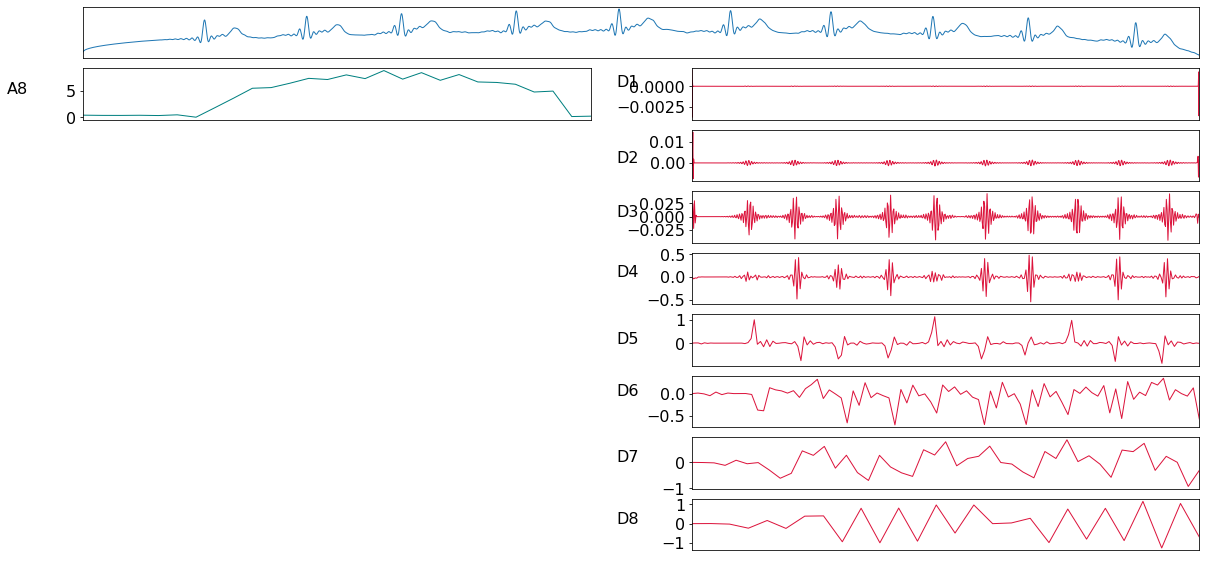

In [86]:
##########################################################################
# TO COMPLETE
##########################################################################

# Import the signal
signal = np.load("Data/CorruptedECG.npy")


#insert your code here. 

# -----------------------------------------------------------------------
# Utility function got from old make_graph file
import matplotlib.pyplot as plt

import numpy as np 
import pywt
import os
root = os.getcwd()
from pathlib import Path

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rcParams.update({'font.size': 16}) 


"""--------------------------------------------------------------------------------------------------
Plot the wavelet decomposition of a singal based on the (previously) computed approximation and 
detail coefficients.
INPUTS: 
    - signal : original sigal vector (without time)
    - coeefs : DWT coefficients in the following order : [cA_n, cD_n, cD_n-1, …, cD_2, cD_1]
--------------------------------------------------------------------------------------------------"""
def print_decomposition(signal, coeffs):
    approx_coeffs, detail_coeffs = coeffs[0], coeffs[1:]
    fig = plt.figure(figsize=(20,10))
    ax_main = fig.add_subplot(len(detail_coeffs) + 1, 1, 1)
    ax_main.plot(signal, linewidth=1)
    ax_main.set_xlim(0, len(signal) - 1)
    ax_main.get_xaxis().set_visible(False)
    ax_main.get_yaxis().set_visible(False)

    ax = fig.add_subplot(len(detail_coeffs) + 1, 2, 3 )
    ax.plot(approx_coeffs, 'teal', linewidth=1)
    ax.set_xlim(0, len(approx_coeffs) - 1)
    ax.patch.set_alpha(0)
    #ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    plt.text(-(len(approx_coeffs) - 1)*0.15, np.mean(approx_coeffs), "A%d" % len(detail_coeffs))

    for i, y in enumerate(detail_coeffs[::-1]):
        ax = fig.add_subplot(len(detail_coeffs) + 1, 2, 4 + i * 2)
        ax.plot(y, 'crimson', linewidth=1)
        ax.set_xlim(0, len(y) - 1)
        #ax.get_yaxis().set_visible(False)
        if i != len(approx_coeffs)-1:
            ax.get_xaxis().set_visible(False)
        plt.text(-(len(y) - 1)*0.15, np.mean(y), "D%d" % (i + 1))

    # Display graph on screen
    plt.show()
    plt.close()






def get_decomposition(signal, show_graph=True, wavelet_type = 'haar', level=6):     
    """This functions applies a (default=6) level DWT on the signal array for a given wavelet 
    (default=haar) basis function.
    the returned values are the coefficients in the following order : [cA_n, cD_n, cD_n-1, …, cD_2, cD_1]
    """
    coeffs = pywt.wavedec(signal,wavelet_type,level=level)
    if show_graph : 
        print_decomposition(signal, coeffs)
    return coeffs

# End of utility 
# ---------------------------------------------------------------------------

coef = get_decomposition(signal,wavelet_type="db5",level=8)


<div class="alert alert-block alert-info">
<font color=#0053B6>
<b> Question 5 </b><br> 
Identify which level(s) of the decomposition are the most affected by this low frequency artifact. Comment briefly.  
</font>

>The most affected level are the high levels such as 7 or 8, we can also see that the residu A8 is highly affected by it. In the following question we will see that the low frequency noise is mainly in A8

>The low level contain the high frequency component of the signal (we can clearly see them in 2 3 4 and 5)

<div class="alert alert-block alert-info">
<font color=#0053B6>
<b> Question 6 </b><br> 
Modify the coefficient(s) mentionned above in order to remove this artefact from the signal. Then perform the inverse DWT of your modified coefficients to obtain a filtered signal.  <br><br>
    
Provide a plot of: 
<ol>
    <li> the original signal (with the artifact); 
    <li> your filtered signal (without the artifact);
</ol>
</font>

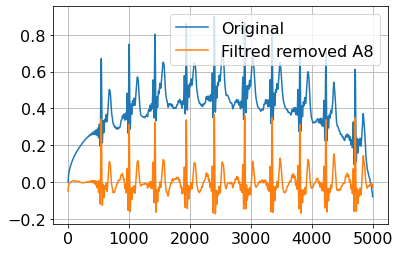

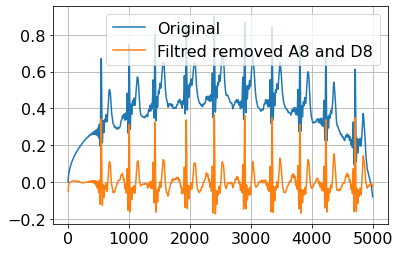

In [99]:
##########################################################################
# TO COMPLETE
##########################################################################

#insert your code here.
import copy

# Copy the list to not destroy them

# Two different filter will be made to compare. See conclusion below
to_filter = copy.deepcopy(coef)
to_filter_bis = copy.deepcopy(coef)

to_delete = [0,1]
to_delete_bis = [0,1]

# First filtering
for k in to_delete:
    n_list = [0 for _ in range(len(to_filter[k]))]
    to_filter[k] = np.array(n_list)

# Second filtering
for k in to_delete_bis:
    n_list = [0 for _ in range(len(to_filter_bis[k]))]
    to_filter_bis[k] = np.array(n_list)
    
    
# Reconstruction
filtred = pywt.waverec(to_filter,"db5")

filtred_bis = pywt.waverec(to_filter_bis,"db5")

# First plot
plt.figure()
plt.plot(signal,label="Original")
plt.plot(filtred_bis,label="Filtred removed A8")

plt.legend()
plt.grid()
plt.show()

# Second plot
plt.figure()
plt.plot(signal,label="Original")
plt.plot(filtred,label="Filtred removed A8 and D8")

plt.legend()
plt.grid()
plt.show()

>From the two above plot we can see that the low frequency noise is contained majoratively in A8 as filtering D8 does not really change the result.